In [76]:
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import datetime as dt

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20, 6)

In [78]:
import sklearn
from sklearn.metrics import (
    mean_squared_error as mse,
    mean_absolute_error as mae,
    mean_absolute_percentage_error as mape
)

In [79]:
def performance(actual, predicted):
    print('MAE', round(mae(actual, predicted), 3))
    print('RMSE', round(mse(actual, predicted)**0.5, 3))
    print('MAPE', round(mape(actual, predicted), 3))

In [80]:
def adf_test(data, significance_level = 0.05):
    pvalue = sm.tsa.stattools.adfuller(data)[1]
    if pvalue <= significance_level:
        print('Sequence is stationary')
    else:
        print('Sequence is not stationary')

In [81]:
mobile_sales = pd.read_excel('mobilesales.xlsx')

In [82]:
mobile_sales.set_index('DATE',inplace=True)
mobile_sales

,Sales
DATE,
2001-01-01,6519.0
2001-02-01,6654.0
2001-03-01,7332.0
2001-04-01,7332.0
2001-05-01,8240.0
...,...
2018-09-01,13838.0
2018-10-01,15351.0
2018-11-01,15615.0


In [83]:
mobile_sales.Sales = mobile_sales.Sales.interpolate(method= 'linear')
mobile_sales.Sales

DATE
2001-01-01     6519.0
2001-02-01     6654.0
2001-03-01     7332.0
2001-04-01     7332.0
2001-05-01     8240.0
               ...   
2018-09-01    13838.0
2018-10-01    15351.0
2018-11-01    15615.0
2018-12-01    16941.0
2019-01-01    12160.0
Name: Sales, Length: 217, dtype: float64

## Clipping

In [84]:
mobile_sales.Sales = mobile_sales.Sales.clip(upper=mobile_sales.Sales.quantile(0.95), lower=mobile_sales.Sales.quantile(0.05))

In [85]:
train_max_date = mobile_sales.index[-12]
train_x = mobile_sales.loc[mobile_sales.index < mobile_sales.index[-12]]
test_x = mobile_sales.loc[mobile_sales.index >= mobile_sales.index[-12]]

## SARIMA Model

C:\Users\ryanr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ryanr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ryanr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: display. After release 0.14, this will raise.
  warnings.warn(
C:\Users\ryanr\AppData\Local\Programs\Python\Python312\Lib\site-package

MAE 429.653
RMSE 527.87
MAPE 0.03


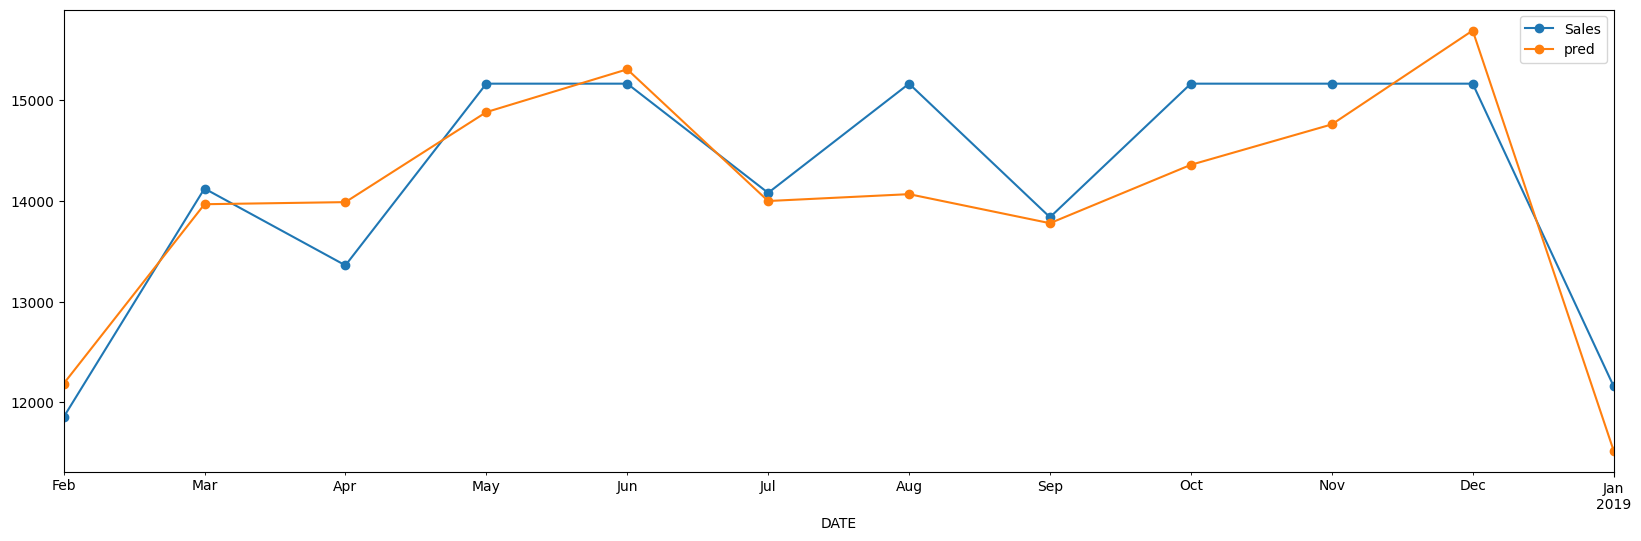

In [86]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train_x.Sales, order=(3,1,3), seasonal_order=(1,1, 1, 12)) #ARMA(10,5)
model = model.fit(display=False)
test_x['pred'] = model.forecast(steps=12)

#test_x['pred'] = test_x['pred'].cumsum() + train_x.Sales[-1] ## Not required



test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

## Confidence Interval

In [87]:
model.get_forecast(steps=12).conf_int(0.01)

,lower Sales,upper Sales
2018-02-01,10712.873203,13654.744616
2018-03-01,12444.983715,15489.473481
2018-04-01,12459.634248,15516.409449
2018-05-01,13344.283208,16419.841366
2018-06-01,13730.284461,16883.758163
2018-07-01,12420.339769,15577.775397
2018-08-01,12462.089923,15672.319278
2018-09-01,12156.465930,15401.038844
2018-10-01,12731.177681,15985.963406
2018-11-01,13101.455657,16418.296874


In [88]:
test_x[['lower', 'upper']] = model.get_forecast(steps=12).conf_int(0.01).values

C:\Users\ryanr\AppData\Local\Temp\ipykernel_19936\3919164794.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_x[['lower', 'upper']] = model.get_forecast(steps=12).conf_int(0.01).values
C:\Users\ryanr\AppData\Local\Temp\ipykernel_19936\3919164794.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_x[['lower', 'upper']] = model.get_forecast(steps=12).conf_int(0.01).values


In [89]:
test_x

,Sales,pred,lower,upper
DATE,,,,
2018-02-01,11852.0,12183.808909,10712.873203,13654.744616
2018-03-01,14123.0,13967.228598,12444.983715,15489.473481
2018-04-01,13360.0,13988.021849,12459.634248,15516.409449
2018-05-01,15164.6,14882.062287,13344.283208,16419.841366
2018-06-01,15164.6,15307.021312,13730.284461,16883.758163
2018-07-01,14080.0,13999.057583,12420.339769,15577.775397
2018-08-01,15164.6,14067.204600,12462.089923,15672.319278
2018-09-01,13838.0,13778.752387,12156.465930,15401.038844
2018-10-01,15164.6,14358.570543,12731.177681,15985.963406


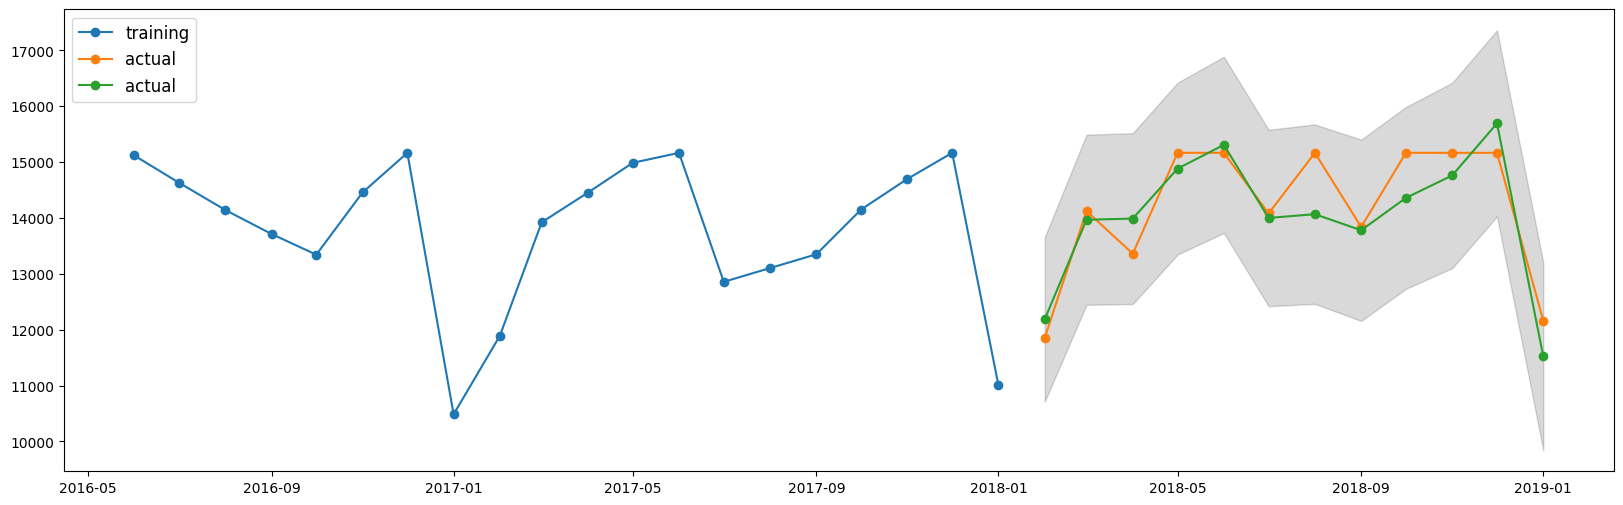

In [90]:
plt.plot(train_x['Sales'][-20:], '-o', label='training')

plt.plot(test_x['Sales'], '-o', label='actual')
plt.plot(test_x['pred'], '-o', label='actual')

plt.fill_between(test_x.index, test_x['lower'], test_x['upper'], color='k', alpha=.15)

plt.legend(loc='upper left', fontsize=12)

plt.show();


In [91]:
#95% confidence interval
model.get_forecast(steps=1).conf_int(0.05)

,lower Sales,upper Sales
2018-02-01,10712.873203,13654.744616


## Food Business
Predict the number of visotors in the next six weeks!


In [92]:
#!gdown 16TAoRZ3S8ebgIq3dPQmWIXPw_1dZy3ta

In [93]:
df = pd.read_csv('rest_vis.csv')
df.head()

,date,weekday,holiday,total
0,1/1/2016,Friday,1,296.0
1,1/2/2016,Saturday,0,191.0
2,1/3/2016,Sunday,0,202.0
3,1/4/2016,Monday,0,105.0
4,1/5/2016,Tuesday,0,98.0


In [94]:
df.shape

(517, 4)

In [95]:
df.isna().sum()

date        0
weekday     0
holiday     0
total      39
dtype: int64

In [96]:
df.tail()

,date,weekday,holiday,total
512,5/27/2017,Saturday,0,NaN
513,5/28/2017,Sunday,0,NaN
514,5/29/2017,Monday,1,NaN
515,5/30/2017,Tuesday,0,NaN
516,5/31/2017,Wednesday,0,NaN


In [97]:
517 - 39

478

In [98]:
df1 = df.copy()

In [99]:
df.dropna(inplace=True)

In [100]:
df.head()

,date,weekday,holiday,total
0,1/1/2016,Friday,1,296.0
1,1/2/2016,Saturday,0,191.0
2,1/3/2016,Sunday,0,202.0
3,1/4/2016,Monday,0,105.0
4,1/5/2016,Tuesday,0,98.0


In [101]:
df.shape

(478, 4)

In [102]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.head(5)

,weekday,holiday,total
date,,,
2016-01-01,Friday,1,296.0
2016-01-02,Saturday,0,191.0
2016-01-03,Sunday,0,202.0
2016-01-04,Monday,0,105.0
2016-01-05,Tuesday,0,98.0


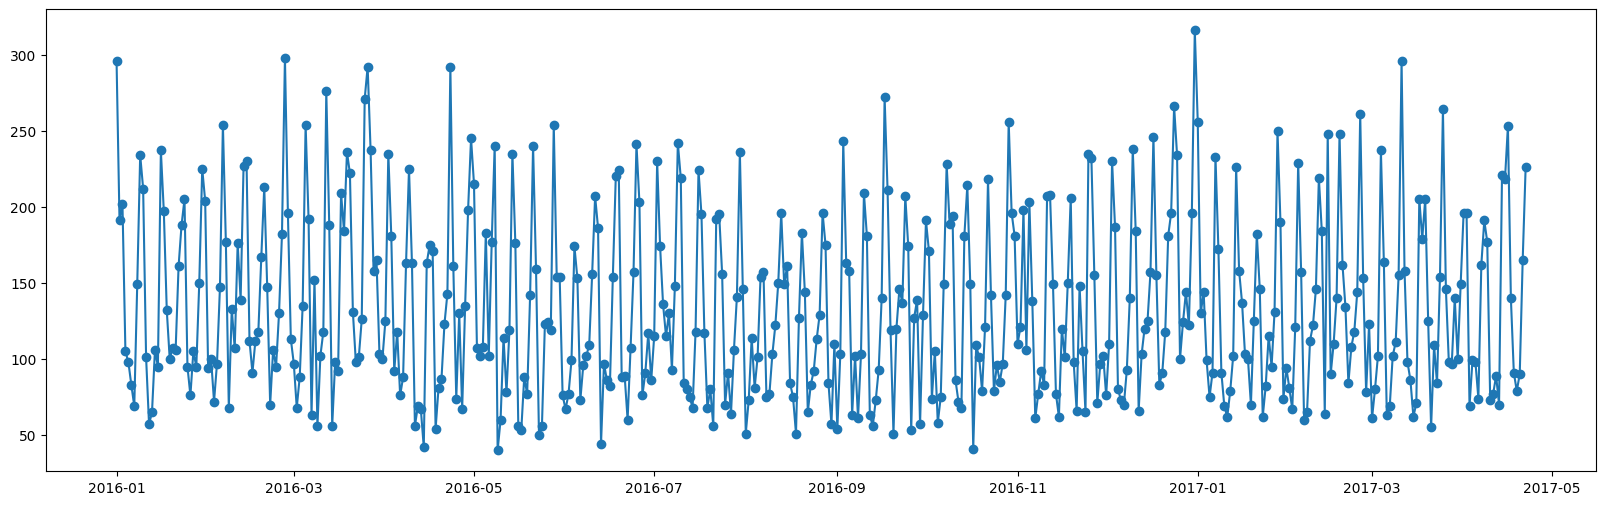

In [103]:
plt.plot(df.index, df['total'], '-o')
plt.show();

On closer observation, seasonality can be observed!

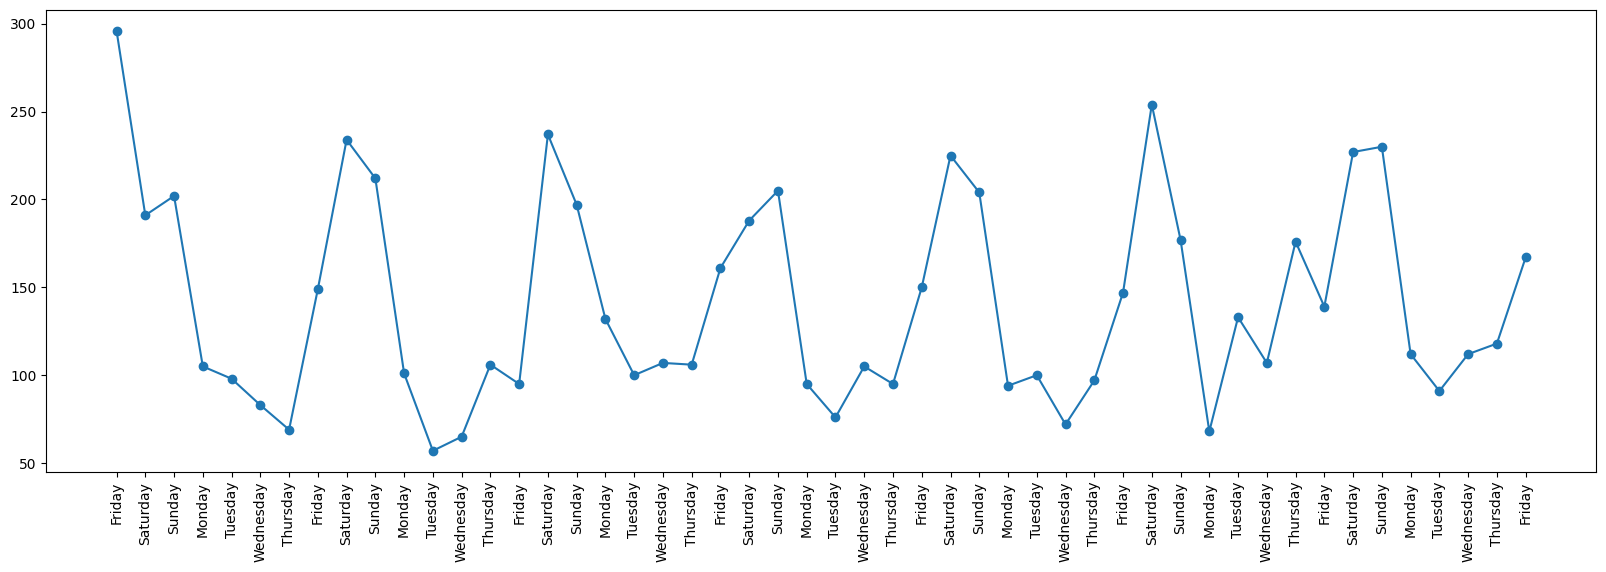

In [104]:
plt.plot(range(50), df['total'][:50], '-o')
plt.xticks(range(0,50), df['weekday'][:50], rotation=90)
plt.show();

In [105]:
df['holiday'].value_counts()

holiday
0    446
1     32
Name: count, dtype: int64

C:\Users\ryanr\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\plotting\_matplotlib\core.py:981: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  return ax.plot(*args, **kwds)


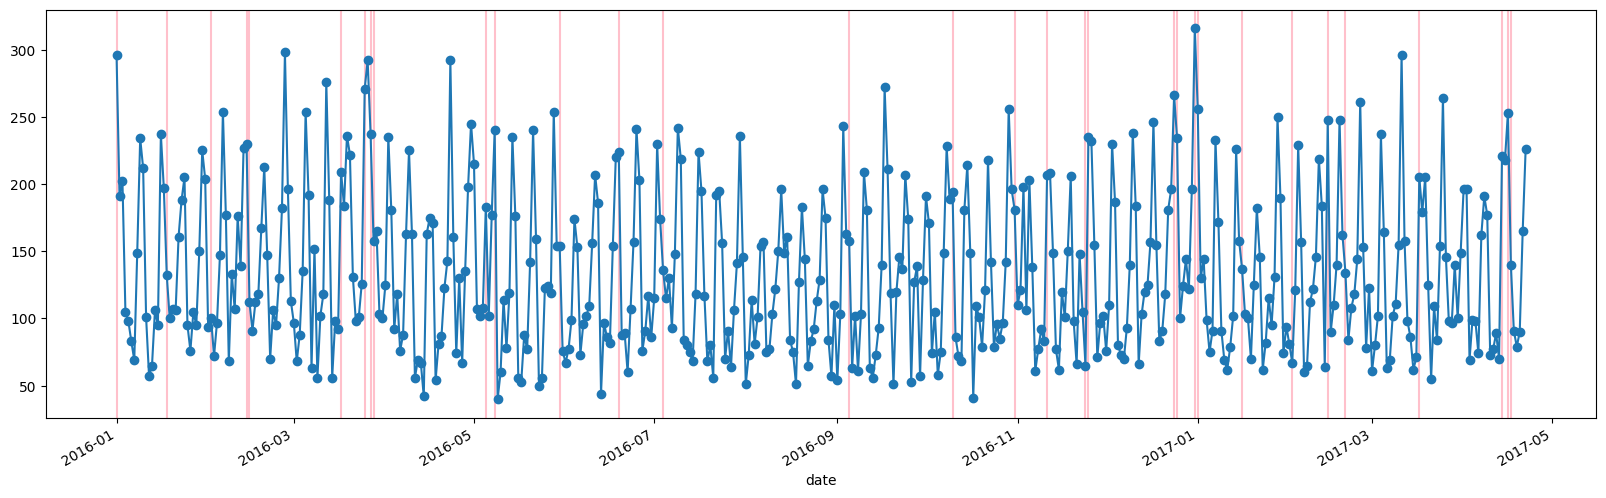

In [106]:
holidays = df.loc[df.holiday==1].index
for hday in holidays:
    plt.axvline(x=hday, color='pink')
df.total.plot(style='-o')
plt.show()

In [107]:
df.shape

(478, 3)

In [108]:
478 - 436 

42

In [109]:
42/7

6.0

In [110]:
train = df.iloc[:436]
test = df.iloc[436:]

In [111]:
train.head()

,weekday,holiday,total
date,,,
2016-01-01,Friday,1,296.0
2016-01-02,Saturday,0,191.0
2016-01-03,Sunday,0,202.0
2016-01-04,Monday,0,105.0
2016-01-05,Tuesday,0,98.0


In [112]:
adf_test(df.total)

Sequence is stationary


In [113]:
#SARIMAX(order = (p,d,q), seasonal_order=(P,D,Q,s))
model = SARIMAX(train['total'], order=(1,0,1), seasonal_order = (1, 0, 1, 7))
results = model.fit(disp = False)
predictions = results.forecast(steps=42)

C:\Users\ryanr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\ryanr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [114]:
predictions

2017-03-12    185.216754
2017-03-13     98.355410
2017-03-14    106.422161
2017-03-15    103.342767
2017-03-16    104.621579
2017-03-17    146.783024
2017-03-18    237.224420
2017-03-19    177.465097
2017-03-20     91.833229
2017-03-21    100.923368
2017-03-22     98.707733
2017-03-23    100.713698
2017-03-24    143.481481
2017-03-25    234.425296
2017-03-26    175.110178
2017-03-27     89.857993
2017-03-28     99.255540
2017-03-29     97.300426
2017-03-30     99.525294
2017-03-31    142.471195
2017-04-01    233.556642
2017-04-02    174.381749
2017-04-03     89.253131
2017-04-04     98.742303
2017-04-05     96.865904
2017-04-06     99.156496
2017-04-07    142.151459
2017-04-08    233.269803
2017-04-09    174.143520
2017-04-10     89.061280
2017-04-11     98.577042
2017-04-12     96.724564
2017-04-13     99.034715
2017-04-14    142.039845
2017-04-15    233.158317
2017-04-16    174.053031
2017-04-17     88.993903
2017-04-18     98.516657
2017-04-19     96.671585
2017-04-20     98.987383


MAE 24.668
RMSE 31.61
MAPE 0.203


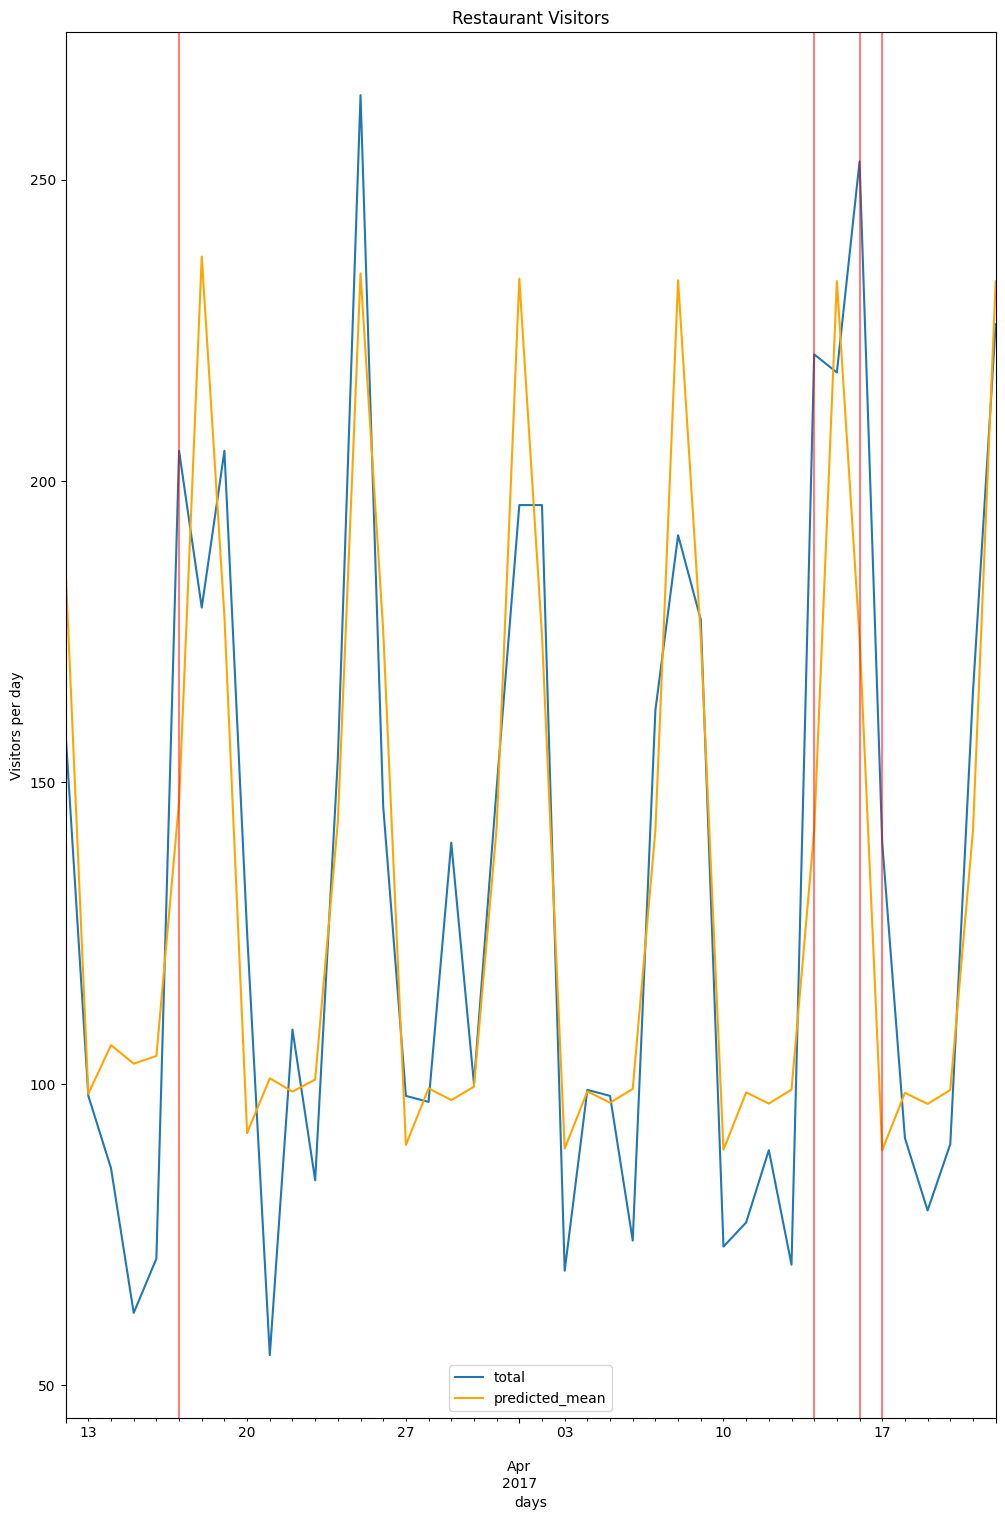

In [115]:
performance(test['total'], predictions)

title = 'Restaurant Visitors'
ylabel = 'Visitors per day'
xlabel = 'days'
ax = test['total'].plot(legend=True, figsize=(12, 18), title = title)
predictions.plot(legend = True, color = 'orange')

ax.autoscale(axis='x', tight = True)
ax.set(xlabel=xlabel, ylabel = ylabel)
for x in test.query('holiday==1').index:
    ax.axvline(x=x, color='red', alpha=0.5)

Bad predictions on holidays. The model does not take into consideration the (exogenous) variable "holiday"

## With exogenous variable

In [119]:
#SARIMAX(order = (p,d,q), exog = df["holiday"], seasonal_order=(P,D,Q,s))
model = SARIMAX(train['total'], exog = train['holiday'], order=(1,0,1), seasonal_order = (1, 0, 1, 7))
results = model.fit(disp = False)

C:\Users\ryanr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\ryanr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


C:\Users\ryanr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\ryanr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [123]:
#Exog must be in the form of a dataframe df[["holiday"]]
predictions = results.forecast(42, exog = test[['holiday']])

MAE 18.495
RMSE 22.996
MAPE 0.159


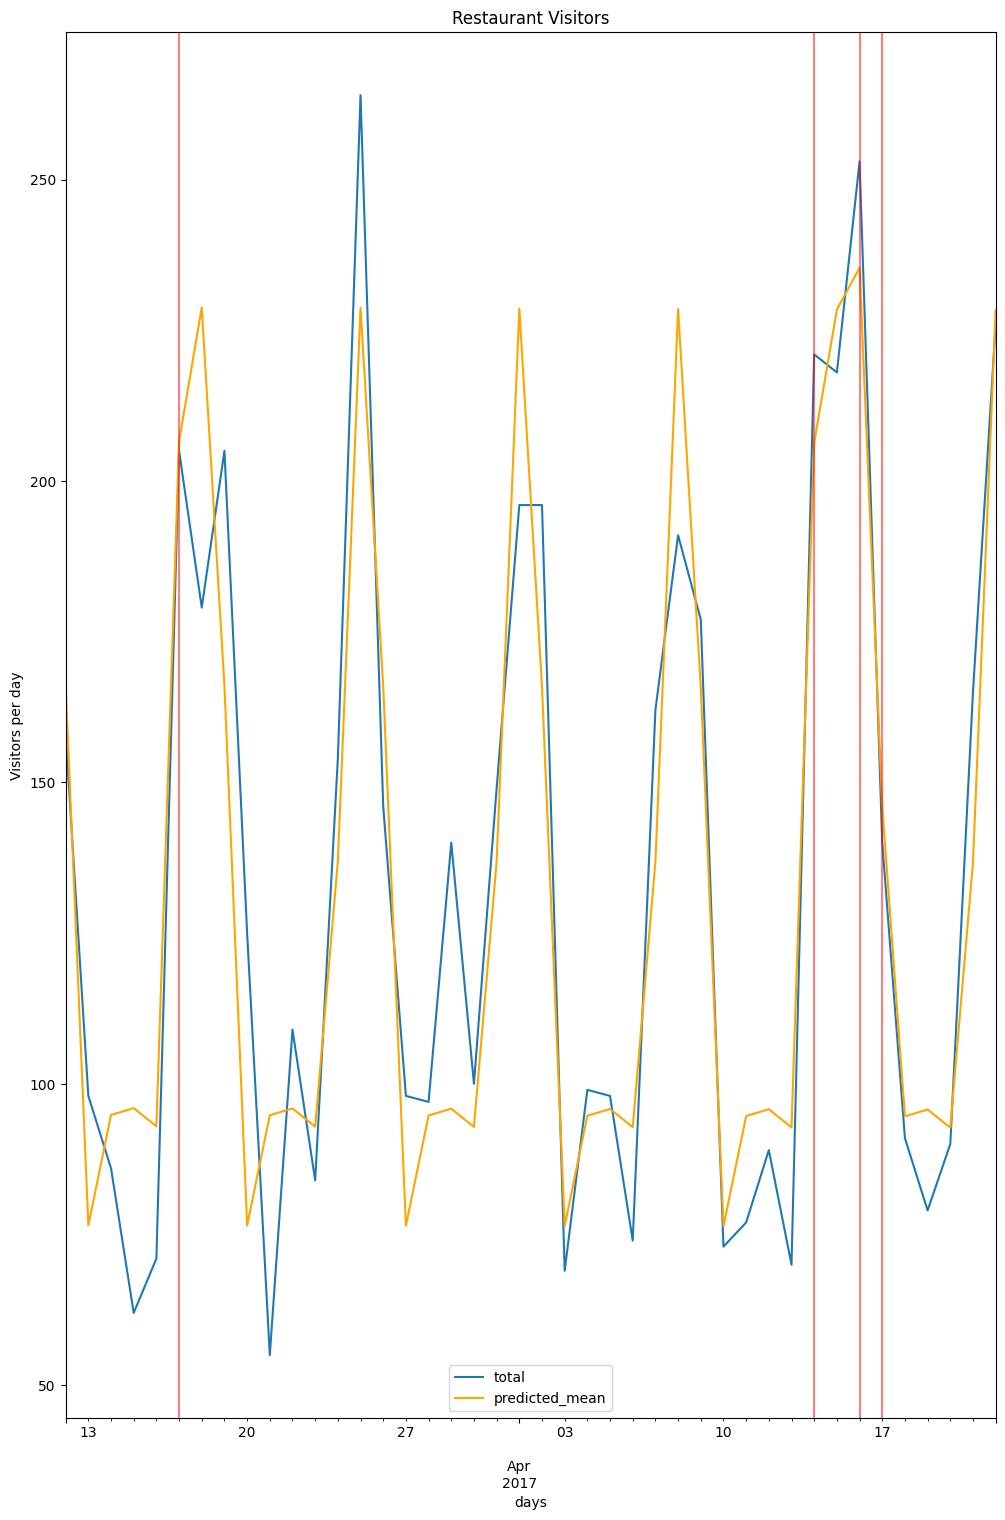

In [124]:
performance(test['total'], predictions)

title = 'Restaurant Visitors'
ylabel = 'Visitors per day'
xlabel = 'days'
ax = test['total'].plot(legend=True, figsize=(12, 18), title = title)
predictions.plot(legend = True, color = 'orange')

ax.autoscale(axis='x', tight = True)
ax.set(xlabel=xlabel, ylabel = ylabel)
for x in test.query('holiday==1').index:
    ax.axvline(x=x, color='red', alpha=0.5)